## Primary Objective:

The main challenge is to predict a patient’s lung function decline over time, typically measured via forced vital capacity (FVC).

In [40]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

In [41]:
# List files available
list(os.listdir("../input/osic-pulmonary-fibrosis-progression"))

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [42]:
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progressiont/"

train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train_df.shape)
train_df.head(5)

Training data shape:   (1549, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [43]:
train_df.groupby(['SmokingStatus']).count()['Sex'].to_frame()

,Sex
SmokingStatus,
Currently smokes,82
Ex-smoker,1038
Never smoked,429


In [44]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(test_df.info())

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non

In [45]:
train_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [46]:
test_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [47]:
# Total number of Patient in the dataset(train+test)

print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['Patient'].count())

Total Patients in Train set:   1549
Total Patients in Test set:   5


In [48]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train_df['Patient'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train_df['Patient'].value_counts().shape[0]}.")

The total patient ids are  1549, from those the unique ids are  176.


In [49]:
train_patient_ids = set(train_df['Patient'].unique())
test_patient_ids = set(test_df['Patient'].unique())

train_patient_ids.intersection(test_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

In [50]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus']


In [51]:
train_df['Patient'].value_counts().max()

10

In [52]:
test_df['Patient'].value_counts().max()

1

In [53]:
files = folders = 0

path = "/kaggle/input/osic-pulmonary-fibrosis-progression/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

33,026  files/images, 176  folders/patients


In [54]:
files = []
for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files.append(len(filenames))

print(Fore.YELLOW +f'{round(np.mean(files)):,}',Style.RESET_ALL,'average files/images per patient')
print(Fore.BLUE +f'{round(np.max(files)):,}',Style.RESET_ALL, 'max files/images per patient')

187  average files/images per patient
1,018  max files/images per patient


In [55]:
patient_df = train_df[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates()
patient_df.head()

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
9,ID00009637202177434476278,69,Male,Ex-smoker
18,ID00010637202177584971671,60,Male,Ex-smoker
27,ID00011637202177653955184,72,Male,Ex-smoker
36,ID00012637202177665765362,65,Male,Never smoked


In [56]:
# Creating unique patient lists and their properties. 
train_dir = '../input/osic-pulmonary-fibrosis-progression/train/'
test_dir = '../input/osic-pulmonary-fibrosis-progression/test/'

patient_ids = os.listdir(train_dir)
patient_ids = sorted(patient_ids)

#Creating new rows
no_of_instances = []
age = []
sex = []
smoking_status = []

for patient_id in patient_ids:
    patient_info = train_df[train_df['Patient'] == patient_id].reset_index()
    no_of_instances.append(len(os.listdir(train_dir + patient_id)))
    age.append(patient_info['Age'][0])
    sex.append(patient_info['Sex'][0])
    smoking_status.append(patient_info['SmokingStatus'][0])

#Creating the dataframe for the patient info    
patient_df = pd.DataFrame(list(zip(patient_ids, no_of_instances, age, sex, smoking_status)), 
                                 columns =['Patient', 'no_of_instances', 'Age', 'Sex', 'SmokingStatus'])
print(patient_df.info())
patient_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient          176 non-null    object
 1   no_of_instances  176 non-null    int64 
 2   Age              176 non-null    int64 
 3   Sex              176 non-null    object
 4   SmokingStatus    176 non-null    object
dtypes: int64(2), object(3)
memory usage: 7.0+ KB
None


,Patient,no_of_instances,Age,Sex,SmokingStatus
0,ID00007637202177411956430,30,79,Male,Ex-smoker
1,ID00009637202177434476278,394,69,Male,Ex-smoker
2,ID00010637202177584971671,106,60,Male,Ex-smoker
3,ID00011637202177653955184,31,72,Male,Ex-smoker
4,ID00012637202177665765362,49,65,Male,Never smoked


In [57]:
patient_df['SmokingStatus'].value_counts()
patient_df['SmokingStatus'].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the SmokingStatus column in the Unique Patient Set')

In [58]:
train_df['Weeks'].value_counts().head()
train_df['Weeks'].value_counts().iplot(kind='barh',
                                      xTitle='Counts(Weeks)', 
                                      linecolor='black', 
                                      opacity=0.7,
                                      color='#FB8072',
                                      theme='pearl',
                                      bargap=0.2,
                                      gridcolor='white',
                                      title='Distribution of the Weeks in the training set')

In [59]:
train_df['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')

In [60]:
fig = px.scatter(train_df, x="Weeks", y="Age", color='Sex')
fig.show()

In [61]:
train_df['FVC'].value_counts()

FVC
2474    4
2965    4
2889    4
2095    4
2708    4
       ..
3906    1
3780    1
3925    1
3907    1
2774    1
Name: count, Length: 1202, dtype: int64

In [62]:
train_df['FVC'].iplot(kind='hist',
                      xTitle='Lung Capacity(ml)', 
                      linecolor='black', 
                      opacity=0.8,
                      color='#FB8072',
                      bargap=0.5,
                      gridcolor='white',
                      title='Distribution of the FVC in the training set')

In [63]:
fig = px.scatter(train_df, x="FVC", y="Percent", color='Age')
fig.show()

In [64]:
fig = px.scatter(train_df, x="FVC", y="Age", color='Sex')
fig.show()

In [65]:
patient = train_df[train_df.Patient == 'ID00228637202259965313869']
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [66]:
train_df['Percent'].value_counts()
train_df['Percent'].iplot(kind='hist',bins=30,color='blue',xTitle='Percent distribution',yTitle='Count')

In [67]:
patient_df['SmokingStatus'].value_counts()

SmokingStatus
Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: count, dtype: int64

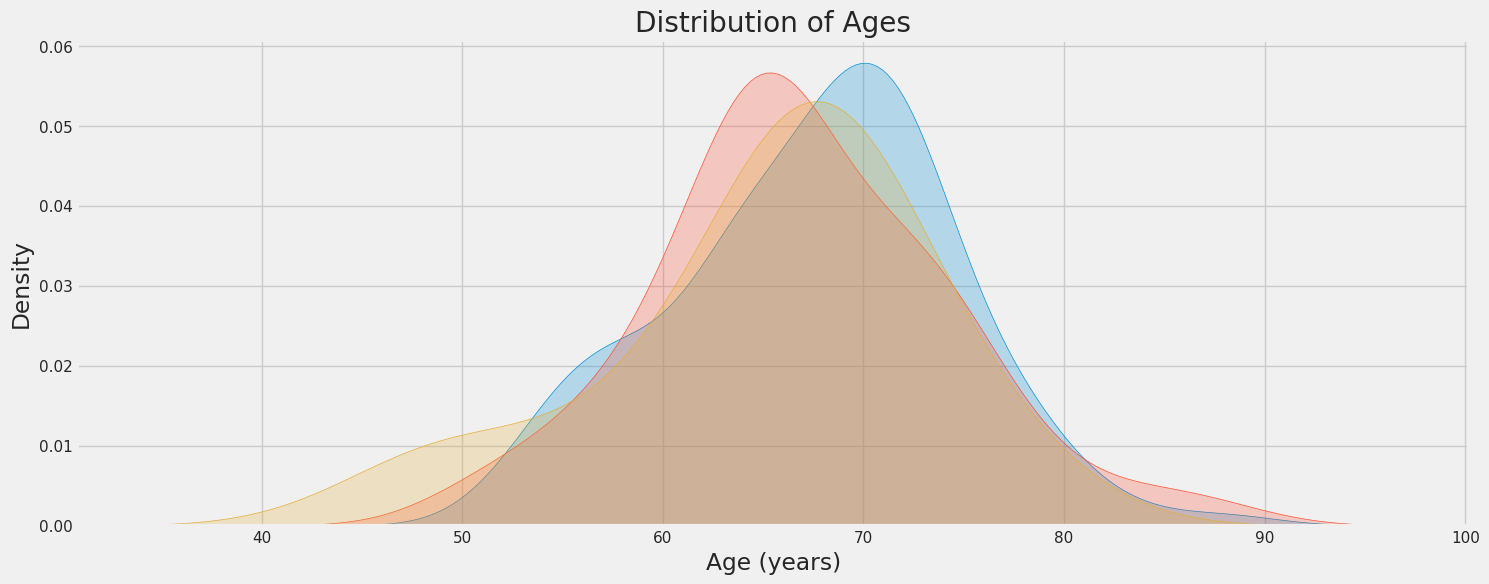

In [68]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


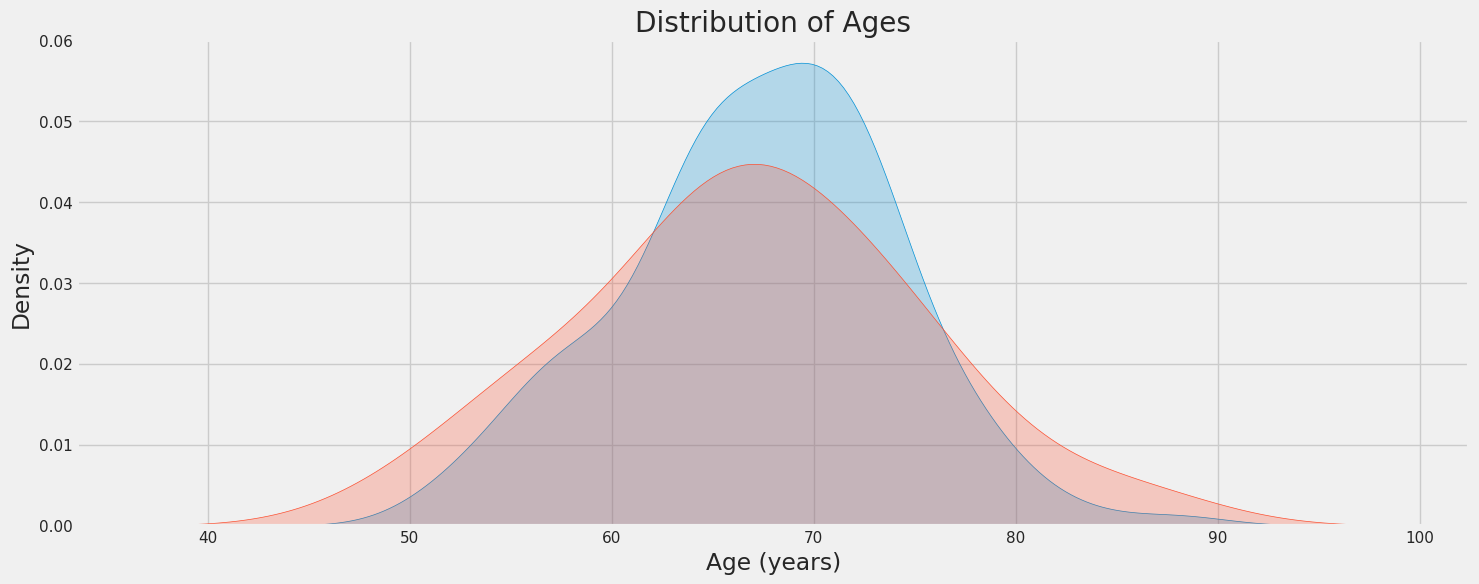

In [69]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Male', 'Age'], label = 'Male',shade=True)
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Female', 'Age'], label = 'Female',shade=True)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [70]:
patient_df['Sex'].value_counts()

Sex
Male      139
Female     37
Name: count, dtype: int64

In [71]:
patient_df['Sex'].value_counts().iplot(kind='bar',
                                          yTitle='Count', 
                                          linecolor='black', 
                                          opacity=0.7,
                                          color='blue',
                                          theme='pearl',
                                          bargap=0.8,
                                          gridcolor='white',
                                          title='Distribution of the Sex column in Patient Dataframe')

Filename.........:  ../input/osic-pulmonary-fibrosis-progression/train/ID00015637202177877247924/377.dcm

Patient's name......:  ID00015637202177877247924, 
Patient id..........:  ID00015637202177877247924
Patient's Sex.......:  
Modality............:  CT
Body Part Examined..:  Chest
Image size.......:   768 x 768, 1179648 bytes
Pixel spacing....:  [0.522135417, 0.522135417]


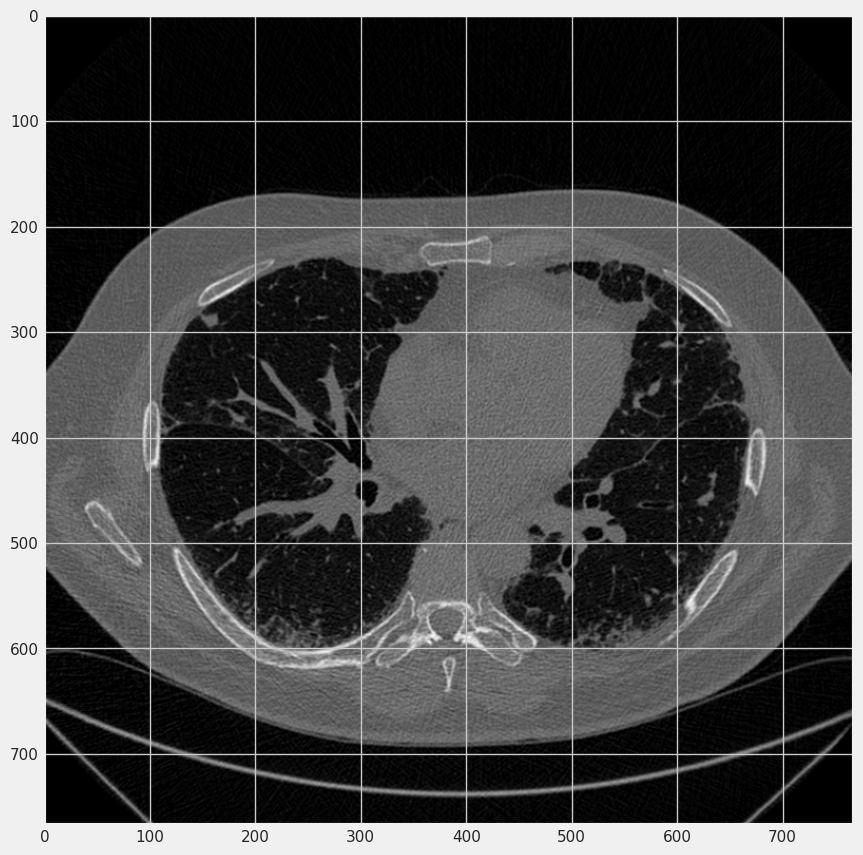

In [72]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array, cmap='gray') # cmap=plt.cm.bone)
    plt.show()

def show_dcm_info(dataset):
    print(Fore.YELLOW + "Filename.........:",Style.RESET_ALL,file_path)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print(Fore.BLUE + "Patient's name......:",Style.RESET_ALL, display_name)
    print(Fore.BLUE + "Patient id..........:",Style.RESET_ALL, dataset.PatientID)
    print(Fore.BLUE + "Patient's Sex.......:",Style.RESET_ALL, dataset.PatientSex)
    print(Fore.YELLOW + "Modality............:",Style.RESET_ALL, dataset.Modality)
    print(Fore.GREEN + "Body Part Examined..:",Style.RESET_ALL, dataset.BodyPartExamined)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print(Fore.BLUE + "Image size.......:",Style.RESET_ALL," {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print(Fore.YELLOW + "Pixel spacing....:",Style.RESET_ALL,dataset.PixelSpacing)
            dataset.PixelSpacing = [1, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.show()
for file_path in glob.glob('../input/osic-pulmonary-fibrosis-progression/train/*/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    break # Comment this out to see all

total images for patient ID00123637202217151272140:  258


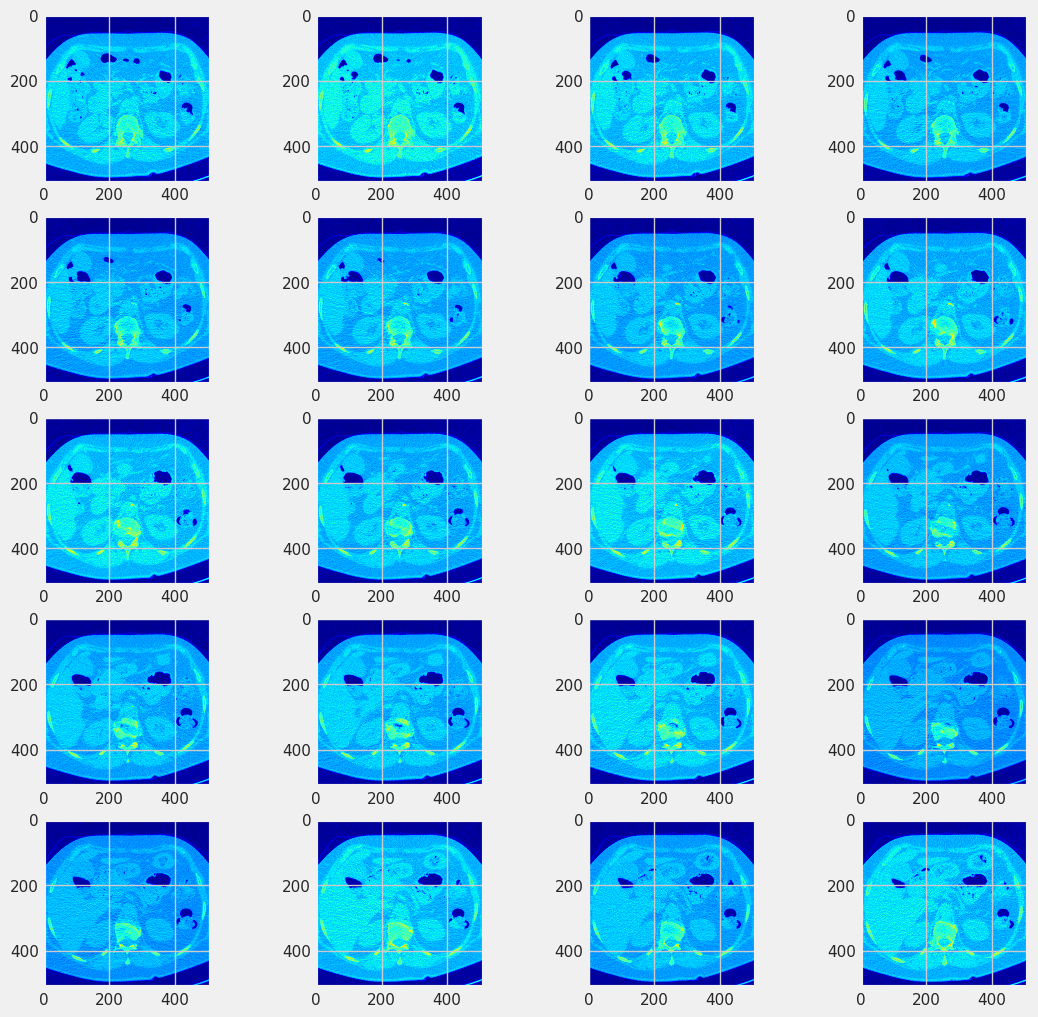

In [73]:
imdir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='jet')
plt.show()